# Steps

* Map 'RainTomorrow' and 'RainToday'
* Remove outliers
* Handle missing data
* Drop unnecessary features
* Standarize
* Encode

In [16]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import yaml
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from sklearn.model_selection import train_test_split

def split_data_and_save(data_path, test_size):
    """
    Splits a DataFrame into training and testing sets.

    Args:
        df (pd.DataFrame): The DataFrame to split.
        test_size (float): Proportion of the dataset to include in the test split (between 0 and 1).

    Returns:
        tuple: (train_df, test_df) Training and testing DataFrames.
    """
    df = pd.read_csv(f"{data_path}/weatherAUS.csv")
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df.to_csv(f"{data_path}/train_weatherAUS.csv")
    test_df.to_csv(f"{data_path}/test_weatherAUS.csv")


def load_features(features_path: str):
    """Cargar archivo YAML de configuración"""
    with open(features_path, 'r') as file:
        return yaml.safe_load(file)

def get_data(data_path: str) -> pd.DataFrame:
    return(pd.read_csv(data_path))

def handle_missing_data(df, threshold=0.1):
    """
    Handles missing data by excluding features with missing values exceeding a certain threshold 
    and removing rows with missing values in features below the threshold.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - threshold (float): The threshold percentage of missing values. Features with missing values 
      exceeding this threshold will be excluded. Default is 0.2 (20%).

    Returns:
    - pd.DataFrame: The dataframe after handling missing data.
    """
    
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean()
    
    # Find columns to drop (those that exceed the threshold)
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    # Find columns to keep
    columns_to_keep = missing_percentage[missing_percentage <= threshold].index
    
    # Store the number of columns to drop
    num_columns_dropped = len(columns_to_drop)
    
    # Exclude columns with missing values greater than the threshold
    df = df[columns_to_keep]
    
    # Count the number of rows with missing values in the remaining columns
    rows_with_missing_values = df.isnull().any(axis=1).sum()  # Count rows with at least one NaN
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Output the information on dropped columns and rows
    print(f"Number of columns dropped: {num_columns_dropped}")
    print(columns_to_drop)
    print(f"Number of rows dropped: {rows_with_missing_values}")
    
    return df


def map_binary_columns(df, columns, mapping={'No': 0, 'Yes': 1}):
    """
    Applies a binary mapping to specified columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        columns (list): List of column names to apply the mapping to.
        mapping (dict): Dictionary defining the binary mapping (default is {'No': 0, 'Yes': 1}).

    Returns:
        pd.DataFrame: A new DataFrame with the specified columns mapped.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(mapping)
    return df


def remove_upper_outliers(df, features, quantile=0.99):
    """
    Removes upper outliers from specified features in a DataFrame 
    based on a given quantile threshold.

    Parameters:
        df (pd.DataFrame): The DataFrame to filter.
        features (list): List of column names to process.
        quantile (float): The quantile to use as the upper limit (default is 0.99).

    Returns:
        pd.DataFrame: A filtered DataFrame with upper outliers removed.
    """
    df = df.copy()
    for feature in features:
        if feature in df.columns:
            threshold = df[feature].quantile(quantile)
            df = df[(df[feature] < threshold) | df[feature].isnull()]
    return df


def get_numerical_and_categorical_columns(df):
    """
    Identifies numerical and categorical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        tuple: A tuple with two lists:
            - numerical_columns: Columns with numeric data types.
            - categorical_columns: Columns with object or category data types.
    """
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numerical_columns, categorical_columns


In [3]:
target = 'RainTomorrow'

features_path = '../config/process/process1.yaml'
config = load_features(features_path=features_path)

data_path = '../data/raw/weatherAUS.csv'
df = get_data(data_path)

df1 = handle_missing_data(df, threshold=0.1)

features_to_map = ['RainToday', 'RainTomorrow']
df2 = map_binary_columns(df1, columns=features_to_map)

features_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
df3 = remove_upper_outliers(df2, features=features_with_outliers, quantile=0.99)

features_to_drop = ['Date']
df4 = df3.drop(features_to_drop, axis=1)

numerical_features, categorical_features = get_numerical_and_categorical_columns(df4)
scaler = StandardScaler()
features_to_scale = [col for col in numerical_features if col != target]
df4[features_to_scale] = scaler.fit_transform(df4[features_to_scale])
for col in categorical_features:
    encoder = LabelEncoder()
    df4[col] = encoder.fit_transform(df4[col].astype(str))

df4.reset_index(inplace=True)
X = df4.drop(target, axis=1)
y = df4[target]

<ipython-input-2-3630162c8eb5>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Number of columns dropped: 6
Index(['Evaporation', 'Sunshine', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm'],
      dtype='object')
Number of rows dropped: 23670


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18416
           1       0.76      0.49      0.60      4875

    accuracy                           0.86     23291
   macro avg       0.82      0.72      0.76     23291
weighted avg       0.85      0.86      0.85     23291



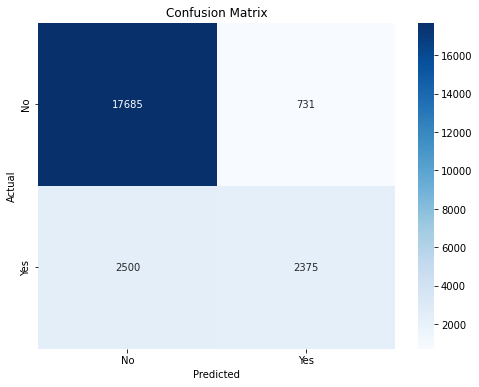

In [5]:
y_pred = rf_model.predict(X_test)

# Mostrar el classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [6]:
def load_config(config_path: str):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def process(config):

    # Cargar las características (si es necesario)
    features = load_features(features_path=config['features_path'])
    
    # Obtener el conjunto de datos
    df = get_data(config['data_path'])

    # Manejar los datos faltantes
    df = handle_missing_data(df, threshold=config.get('missing_data_threshold', 0.2))

    # Mapear las columnas binarias (si es necesario)
    if 'features_to_map' in config:
        df = map_binary_columns(df, columns=config['features_to_map'])

    # Eliminar las columnas con outliers
    if 'features_with_outliers' in config:
        df = remove_upper_outliers(df, features=config['features_with_outliers'])

    # Eliminar las columnas no necesarias
    if 'features_to_drop' in config:
        df.drop(config['features_to_drop'], axis=1, inplace=True)

    # Identificar columnas numéricas y categóricas
    numerical_features, categorical_features = get_numerical_and_categorical_columns(df)

    # Estandarizar las columnas numéricas
    scaler = StandardScaler()
    features_to_scale = [col for col in numerical_features if col != config['target']]
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    # Codificar las columnas categóricas
    for col in categorical_features:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str))

    
    df.reset_index(inplace=True)
    X = df.drop(target, axis=1)
    y = df[target]

    return X, y


In [9]:
#config = load_config('../config/config.yaml')
#X, y = process(config)

# now with classes

In [10]:
# 1. Missing value handler
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.2):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.columns_to_drop_ = X.isnull().mean()[lambda x: x > self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.drop(columns=self.columns_to_drop_)
        return X.dropna()

# 2. Binary mapper
class BinaryMapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, mapping={'No': 0, 'Yes': 1}):
        self.columns = columns
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns or []:
            if col in X.columns:
                X[col] = X[col].map(self.mapping)
        return X

# 3. Outlier remover
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, features=None, quantile=0.99):
        self.features = features
        self.quantile = quantile

    def fit(self, X, y=None):
        self.thresholds_ = {
            feature: X[feature].quantile(self.quantile)
            for feature in self.features or [] if feature in X.columns
        }
        return self

    def transform(self, X):
        X = X.copy()
        for feature, threshold in self.thresholds_.items():
            X = X[(X[feature] < threshold) | X[feature].isnull()]
        return X

# 4. Numerical scaler
class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, exclude=None):
        self.exclude = exclude
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.numerical_features_ = X.select_dtypes(include='number').columns.tolist()
        if self.exclude in self.numerical_features_:
            self.numerical_features_.remove(self.exclude)
        self.scaler.fit(X[self.numerical_features_])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.numerical_features_] = self.scaler.transform(X[self.numerical_features_])
        return X

# 5. Categorical encoder
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.categorical_features_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.encoders_ = {
            col: LabelEncoder().fit(X[col].astype(str))
            for col in self.categorical_features_
        }
        return self

    def transform(self, X):
        X = X.copy()
        for col, encoder in self.encoders_.items():
            X[col] = encoder.transform(X[col].astype(str))
        return X


In [11]:
preprocessing_pipeline = Pipeline(steps=[
    ('missing', MissingValueHandler(threshold=config.get('missing_data_threshold', 0.2))),
    ('binary', BinaryMapper(columns=config.get('features_to_map', []))),
    ('outliers', OutlierRemover(features=config.get('features_with_outliers', []))),
    ('scaling', NumericalScaler(exclude=config['target'])),
    ('encoding', CategoricalEncoder()),
])

In [19]:
split_data_and_save(config['raw_data_path'], test_size=0.2)
df = get_data(f"{config['raw_data_path']}/train_weatherAUS.csv")

df = df.drop(columns=config.get('features_to_drop', []))  # eliminar columnas antes del pipeline

# aplicar el pipeline
df_processed = preprocessing_pipeline.fit_transform(df)

# dividir en X, y
X = df_processed.drop(columns=[config['target']])
y = df_processed[config['target']]

NotADirectoryError: [Errno 20] Not a directory: '../data/raw/weatherAUS.csv/weatherAUS.csv'

In [ ]:
def preprocessing(config):
    """
    Executes the data preprocessing pipeline and returns X, y, and the fitted pipeline.

    Parameters:
        config (dict): Configuration dictionary with paths and preprocessing parameters.

    Returns:
        X (pd.DataFrame): Processed features.
        y (pd.Series): Target variable.
        preprocessing_pipeline (Pipeline): Fitted preprocessing pipeline.
    """
    # Load data
    df = get_data(config['data_path'])

    # Drop unnecessary features
    df = df.drop(columns=config.get('features_to_drop', []))

    # Define the preprocessing pipeline
    preprocessing_pipeline = Pipeline(steps=[
        ('missing', MissingValueHandler(threshold=config.get('missing_data_threshold', 0.2))),
        ('binary', BinaryMapper(columns=config.get('features_to_map', []))),
        ('outliers', OutlierRemover(features=config.get('features_with_outliers', []))),
        ('scaling', NumericalScaler(exclude=config['target'])),
        ('encoding', CategoricalEncoder()),
    ])

    # Fit and transform the pipeline
    df_processed = preprocessing_pipeline.fit_transform(df)

    # Separate features and target
    X = df_processed.drop(columns=[config['target']])
    y = df_processed[config['target']]

    X.to_csv(f"{config['processed_data_path']}/X_train.csv")
    y.to_csv(f"{config['processed_data_path']}/X_train.csv")


    return X, y, preprocessing_pipeline

In [ ]:
config = load_config('../config/config.yaml')
X, y, preprocessing_pipeline = preprocessing(config)

In [ ]:
X

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
0,1,0.117567,-0.108221,-0.206661,13,0.241214,13,14,0.577742,0.524408,0.190140,-1.380413,-1.382962,-1.142455,-0.088435,-0.047870,-0.538281
1,1,-0.841802,0.206845,-0.276405,14,0.241214,6,15,-1.339742,0.291310,-1.237561,-1.235963,-0.970598,-1.041848,-0.041228,0.317768,-0.538281
2,1,0.037620,0.292772,-0.276405,15,0.391345,13,15,0.457900,0.757507,-1.554828,-0.995214,-1.397181,-0.912497,0.556724,0.156887,-0.538281
3,1,-0.553991,0.622159,-0.276405,4,-1.260094,9,0,-0.500842,-1.223831,-1.184683,-1.669313,0.024764,-0.323229,0.100392,0.639531,-0.538281
4,1,0.773137,1.237969,-0.160165,13,0.016018,1,7,-0.980214,0.058211,0.771796,-0.850764,-0.942159,-1.300551,0.053185,1.107548,-0.538281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,36,-1.465392,-0.265754,-0.276405,0,-0.734636,2,0,-0.021471,-0.757634,-0.444394,-1.139664,1.034344,0.884050,-1.268605,-0.179500,-0.538281
145455,36,-1.577319,-0.036615,-0.276405,0,-0.734636,9,1,-0.261157,-0.990733,-0.867416,-1.284113,1.020125,0.754699,-1.158456,0.039883,-0.538281
145456,36,-1.449403,0.235487,-0.276405,6,-1.410225,9,3,-0.261157,-1.223831,-0.603027,-1.428563,0.863711,0.582231,-1.032571,0.347020,-0.538281
145457,36,-1.161592,0.464626,-0.276405,3,-0.284243,9,14,-0.740528,-1.223831,-0.761660,-1.284113,0.508225,0.251666,-0.780802,0.581028,-0.538281
